In [3]:
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import torch
import os
import random

%matplotlib inline
from matplotlib import pyplot as plt

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [145]:
def train_epoch(epoch, rnn_model, optimizer, train_batches, test_batched, batch_size_train, batch_size_test, epochs=500):
    rnn_model.train()
    log_interval = 10
    train_losses = []
    train_counter = []
    for batch_idx, ((data_batch, lengths_batch), target) in enumerate(train_batches):
        rnn_model.zero_grad()
        output = rnn_model(data_batch.to(device), lengths=lengths_batch)
        loss = 0
        for i in range(batch_size_train):
            entry_output = output[lengths_batch[i]-1,i,:]
            entry_output = entry_output.view(1, 18)
            loss += torch.nn.functional.cross_entropy(entry_output, target[i].to(device))

        loss = loss / batch_size_train
        loss.backward()
        if batch_idx % log_interval == 0:
            train_losses.append(loss.item())
            train_counter.append((batch_idx * batch_size_train) + (epoch - 1) * len(train_batches) * batch_size_train)
        optimizer.step()
        optimizer.zero_grad()
    
    return train_counter, train_losses


def test_model(rnn_model, test_batches, batch_size_test):
    rnn_model.eval()
    with torch.no_grad():
        loss = 0
        for (data_batch, batch_lengths), target in test_batches:
            output = rnn_model(data_batch.to(device), lengths=batch_lengths)
            for i in range(batch_size_test):
                entry_output = output[lengths_batch[i]-1,i,:]
                entry_output = entry_output.view(1, 18)
                loss += torch.nn.functional.cross_entropy(entry_output, target[i].to(device))
        loss /= (len(test_batches) * batch_size_test)
    
    return loss.item()
            

def train_model(rnn_model, optimizer, train_batches, test_batches, batch_size_train, batch_size_test, epochs=20):
    log_interval = 10
    train_losses = []
    test_losses = []
    train_counter = []
    test_counter = [i * len(train_batches) * batch_size_train for i in range(epochs)]
    for epoch in range(epochs):
        epoch_train_counter, epoch_train_losses = train_epoch(epoch, rnn_model, optimizer, train_batches, test_batches, batch_size_train, batch_size_test)
        train_counter = train_counter + epoch_train_counter
        train_losses = train_losses + epoch_train_losses
        test_loss = test_model(rnn_model, test_batches, batch_size_test)
        test_losses.append(test_loss)

    return train_counter, train_losses, test_counter, test_losses

In [5]:
def pad(seq, length, padding=None):
    if padding == None:
        padding = 0
    z = []
    for i in range(length - len(seq)):
        z.append(copy.deepcopy(padding))
    seq = seq + z
    
    return seq

In [6]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

filenames = os.listdir("./datasets/names")
names_data = {}

for filename in filenames:
    f = open(f"./datasets/names/{filename}")
    data = f.read()
    names = list(filter(lambda l: len(l) > 0, map(lambda n: unicode_to_ascii(n.strip()).lower().strip(','), data.split("\n"))))
    names_data[filename.strip(".txt").lower()] = names
    f.close()

languages = list(names_data.keys())
languages.sort()


def standard_basis_vector(n, i):
    x = torch.zeros(n)
    x[i] = 1
    x.to(device)
    return x

def one_hot_code(name):
    line_vector = []
    for c in name:
        letter_vector = [0] * 29
        i = ord(c) - 97
        if i == ord(" ") - 97:
            letter_vector[26] = 1
        elif i == ord("'") - 97:
            letter_vector[27] = 1
        else:
            letter_vector[i] = 1

        line_vector.append(letter_vector)
    
    return line_vector


def one_hot_to_word(name_vec):
    name = ""
    for letter_vec in name_vec:
        num = np.argmax(letter_vec)
        if num == 26:
            name = name + " "
        elif num == 27:
            name = name + "'"
        elif num == 28:
            break
        else:
            name = name + chr(num + 97)
    
    return name


def label_to_vec(lang):
    label_vec = [0] * len(languages)
    i = languages.index(lang)
    label_vec[i] = 1
    
    return label_vec


def vec_to_label(label_vec):
    i = np.argmax(np.array(label_vec))
    return languages[i]


X_tr = []
X_tst = []
Y_tr = []
Y_tst = []

for lang in languages:
    label_vec = label_to_vec(lang)
    lang_names = names_data[lang]
    random.shuffle(lang_names)
    for name in lang_names[:int(0.8 * len(lang_names))]:
        name_vec = one_hot_code(name)
        X_tr.append(name_vec)
        Y_tr.append(label_vec)
    for name in lang_names[int(0.8 * len(lang_names)):]:
        name_vec = one_hot_code(name)
        X_tst.append(name_vec)
        Y_tst.append(label_vec)

train_indices = list(range(len(X_tr)))
test_indices = list(range(len(X_tst)))
random.shuffle(train_indices)
random.shuffle(test_indices)
X_train = list(map(lambda i: X_tr[i], train_indices))
Y_train = list(map(lambda i: Y_tr[i], train_indices))
X_test = list(map(lambda i: X_tst[i], test_indices))
Y_test = list(map(lambda i: Y_tst[i], test_indices))

In [7]:
one_hot_to_word(X_train[3]), vec_to_label(Y_train[3])

('dubatolov', 'russian')

In [8]:
len(X_train[3][0])

29

In [9]:
len(languages)

18

In [10]:
train_set = list(zip(X_train, Y_train))

In [11]:
# train_set = sorted(train_set, key=lambda t: len(t[0]), reverse=True)

In [12]:
test_set = list(zip(X_test, Y_test))

In [45]:
# test_set = sorted(test_set, key=lambda t: len(t[0]), reverse=True)

In [13]:
len(train_set), len(test_set)

(16053, 4021)

In [14]:
len(lang_names)

73

In [15]:
n_epochs = 5
batch_size_train = 5351
batch_size_test = 4021

In [16]:
def batch_to_tensor(data_batch, batchsize):
    batch_tensors = list(map(lambda t: torch.tensor(t, dtype=torch.float32), data_batch))
    return torch.stack(batch_tensors, dim=1)

In [64]:
test = train_set[:10]

In [67]:
list(map(lambda r: (one_hot_to_word(r[0]), languages[np.argmax(r[1])]), test))

[('khoury', 'arabic'),
 ('tumanyan', 'russian'),
 ('pohlebaev', 'russian'),
 ('dubatolov', 'russian'),
 ('wrench', 'english'),
 ('haziahmetov', 'russian'),
 ('lapaev', 'russian'),
 ('muijel', 'russian'),
 ('tilley', 'english'),
 ('mogilner', 'russian')]

In [68]:
test2 = sorted(test, key=lambda r: len(r[0]), reverse=True)

In [69]:
list(map(lambda r: (one_hot_to_word(r[0]), languages[np.argmax(r[1])]), test2))

[('haziahmetov', 'russian'),
 ('pohlebaev', 'russian'),
 ('dubatolov', 'russian'),
 ('tumanyan', 'russian'),
 ('mogilner', 'russian'),
 ('khoury', 'arabic'),
 ('wrench', 'english'),
 ('lapaev', 'russian'),
 ('muijel', 'russian'),
 ('tilley', 'english')]

In [121]:
batched_train_set = []
prev = 0
for i in range(batch_size_train, len(train_set) + 1, batch_size_train):
    batch = train_set[prev:i]
    batch = sorted(batch, key=lambda r: len(r[0]), reverse=True)
    lengths_batch = list(map(lambda r: len(r[0]), batch))
    max_length = max(lengths_batch)
    batch_padded = list(map(lambda s: torch.tensor(pad(s[0], max_length, padding=standard_basis_vector(29, 28)), dtype=torch.float32), batch))
    batch_targets = list(map(lambda r: torch.argmax(torch.tensor(r[1]), dim=0).view(1), batch))
    batched_train_set.append(((torch.stack(batch_padded, dim=1), lengths_batch), batch_targets))
    prev = i

batched_test_set = []
prev = 0
for i in range(batch_size_test, len(test_set) + 1, batch_size_test):
    batch = test_set[prev:i]
    batch = sorted(batch, key=lambda r: len(r[0]), reverse=True)
    lengths_batch = list(map(lambda r: len(r[0]), batch))
    max_length = max(lengths_batch)
    batch_padded = list(map(lambda s: torch.tensor(pad(s[0], max_length, padding=standard_basis_vector(29, 28)), dtype=torch.float32), batch))
    batch_targets = list(map(lambda r: torch.argmax(torch.tensor(r[1]), dim=0).view(1), batch))
    batched_test_set.append(((torch.stack(batch_padded, dim=1), lengths_batch), batch_targets))
    prev = i

In [122]:
batch = batched_train_set[0]
((dbatch_data, _),dbatch_target) = batched_train_set[1]

In [123]:
one_hot_to_word(dbatch_data[:,123, :]), languages[dbatch_target[123]]

('gianakopulos', 'greek')

In [58]:
one_hot_to_word(batched_train_set[0][0][0][:,200,:]), languages[torch.argmax(torch.tensor(batched_train_set[0][0][1][200]))]

('novotortsev', 'arabic')

In [18]:
len(batched_train_set), len(batched_test_set)

(3, 1)

In [19]:
batched_train_set[0][0][0].size(), len(batched_train_set[0][0][1]), len(batched_train_set[0][1])

(torch.Size([17, 5351, 29]), 5351, 5351)

In [20]:
batched_test_set[0][0][0].size(), len(batched_test_set[0][0][1]), len(batched_test_set[0][1])

(torch.Size([17, 4021, 29]), 4021, 4021)

In [21]:
# X_train = []
# X_train_lengths = []
# Y_train = []
# X_test = []
# X_test_lengths = []
# Y_test = []
# for x, y in train_set:
#     X_train.append(torch.tensor(x).float().to(device))
#     X_train_lengths.append(len(x))
#     Y_train.append(np.argmax(torch.tensor(y)))

# Y_train = torch.tensor(Y_train).to(device)

# for x, y in test_set:
#     X_test.append(torch.tensor(x).float().to(device))
#     X_test_lengths.append(len(x))
#     Y_test.append(np.argmax(torch.tensor(y)))

# Y_test = torch.tensor(Y_test).to(device)

In [22]:
# v = torch.stack(X_train, dim=0)

In [23]:
# X_train_padded = torch.nn.utils.rnn.pad_sequence(torch.stack(X_train, dim=1), batch_first=True)
# X_test_padded = torch.nn.utils.rnn.pad_sequence(torch.stach(X_test, dim=1), batch_first=True)

In [24]:
# X_train_padded_packed = torch.nn.utils.rnn.pack_padded_sequence(X_train_padded, X_train_lengths, batch_first=True)

In [25]:
# X_train_padded_packed

In [110]:
class ModelOne(nn.Module):
    
    def __init__(self):
        super(ModelOne, self).__init__()
        self.rnn = nn.RNN(28, 128, 4, nonlinearity="relu", dropout=0.25, batch_first=True)
        self.dense = nn.Linear(128, 18)
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(4, batch_size, 128).to(device)

        return hidden
    
    def forward(self, x, hidden, x_lengths):
        batch_size = x.size(0)
        max_sequence_size = x.size(1)
        # hidden = self.init_hidden(batch_size).float()
        x = torch.nn.utils.rnn.pack_padded_sequence(x, x_lengths, batch_first=True)
        out, hidden = self.rnn(x, hidden)
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        out = out.contiguous()
        out = out.view(-1, 128)
        out = self.dense(out)
        out = out.view(batch_size, max_sequence_size, 18)
        
        indexes = torch.tensor(x_lengths) - 1
        out = out[torch.arange(batch_size), indexes, :]
        
        return F.softmax(out, dim=1)


class ModelOneNew(nn.Module):
    
    def __init__(self, input_dimension, output_dimension, hidden_dimension, number_of_layers):
        super(ModelOneNew, self).__init__()
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        self.hidden_dimension = hidden_dimension
        self.number_of_layers = number_of_layers
        self.rnn = nn.RNN(
            self.input_dimension,
            self.hidden_dimension,
            self.number_of_layers,
            nonlinearity="relu", dropout=0.25,
            batch_first=True)
        self.dense = nn.Linear(128, 18)
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(
            self.number_of_layers,
            batch_size,
            self.hidden_dimension).to(device)

        return hidden
    
    def forward(self, x, lengths=None):
        batch_size = x.size(1)
        max_sequence_size = x.size(1)
        hidden = self.init_hidden(batch_size).float()
        if lengths is not None:
            x = torch.nn.utils.rnn.pack_padded_sequence(x, lengths)
            x, hidden = self.rnn(x, hidden)
            x, _ = torch.nn.utils.rnn.pad_packed_sequence(x)
        else:
            x, hidden = self.rnn(x, hidden)
        
        out = self.dense(x)
        
        return out

In [189]:
model_one = ModelOneNew(29, 18, 128, 4).to(device)

In [147]:
# output = model_one(batched_train_set[0][0][0].to(device), batched_train_set[0][0][1])

In [148]:
# output.size()

In [149]:
one_hot_to_word(batched_train_set[0][0][0]), languages[torch.argmax(torch.tensor(batched_train_set[0][0][1]))]

('to the first page', 'french')

In [190]:
optimizer = optim.Adam(model_one.parameters(), lr=0.001)
train_counter, train_losses, test_counter, test_losses = train_model(model_one, optimizer, batched_train_set, batched_test_set, batch_size_train, batch_size_test, epochs=100)

Text(0, 0.5, 'negative log likelihood loss')

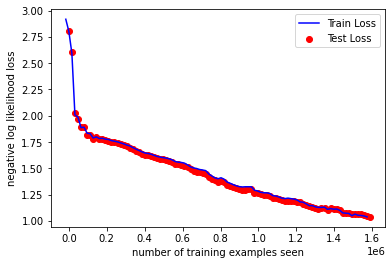

In [191]:
fig = plt.figure()
plt.scatter(test_counter, test_losses, color='red')
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [192]:
batch = batched_test_set[0]
((dbatch_data, batch_lengths),dbatch_target) = batched_train_set[1]

In [193]:
with torch.no_grad():
    output = model_one(dbatch_data.to(device), lengths=batch_lengths)

In [194]:
output.size()

torch.Size([19, 5351, 18])

In [195]:
labels = torch.argmax(output, dim=2)

In [196]:
labels.size()

torch.Size([19, 5351])

In [197]:
ll = []
for i in range(batch_size_test):
    name_length = batch_lengths[i]
    language_name = languages[labels[name_length-1,i].item()]
    ll.append((one_hot_to_word(dbatch_data[:,i,:]), language_name, languages[dbatch_target[i]]))

In [202]:
ll

[('shirinskyshikhmatov', 'russian', 'russian'),
 ('bekovichcherkassky', 'russian', 'russian'),
 ('to the first page', 'russian', 'russian'),
 ('maceachthighearna', 'german', 'irish'),
 ('to the first page', 'russian', 'russian'),
 ('to the first page', 'russian', 'russian'),
 ('to the first page', 'russian', 'russian'),
 ('to the first page', 'russian', 'russian'),
 ('chrysanthopoulos', 'greek', 'greek'),
 ('katzenellenbogen', 'russian', 'russian'),
 ('gorbunovposadov', 'russian', 'russian'),
 ('alexandropoulos', 'greek', 'greek'),
 ('de la fontaine', 'greek', 'french'),
 ('tsaregorodtsev', 'russian', 'russian'),
 ('bakhchivandzhi', 'russian', 'russian'),
 ('tsekhmistrenko', 'russian', 'russian'),
 ('hadjiyianakies', 'greek', 'greek'),
 ('nizhegorodtsev', 'russian', 'russian'),
 ('baistryuchenko', 'russian', 'russian'),
 ('tzekhmistrenko', 'russian', 'russian'),
 ('schwarzenegger', 'german', 'german'),
 ('shakhtmeister', 'russian', 'russian'),
 ('tsvelikhovsky', 'russian', 'russian'),
